In [3]:
import pandas as pd
import numpy as np
import numpy.linalg as la
import scipy.sparse as sp
from scipy.sparse.linalg import svds

df = pd.read_csv('user_song.csv')
num_records = df.shape[0]
test_df = pd.read_csv('test.csv')
num_records

80602

In [4]:
r_avg = df.iloc[:, 2].mean()
r_avg

733.3121758765291

In [5]:
user_deveiation = (df.groupby('user_id')['weight'].mean() - r_avg).to_dict()
song_deveiation = (df.groupby('song_id')['weight'].mean() - r_avg).to_dict()
user_deveiation

{145: -461.1566203209735,
 211: -608.7611554683658,
 1539: 657.0366613327732,
 2214: -724.5295671808769,
 3028: -84.98659448118019,
 3859: -630.1871758765291,
 5334: -464.235252799606,
 5545: -318.14938517885463,
 5795: -125.00985029513367,
 6135: -553.601064765418,
 7848: -732.3121758765291,
 8724: 329.3696423052892,
 8900: -274.8359854003386,
 9034: -128.6048588033583,
 9072: -201.06773143208466,
 9421: -583.1726409928082,
 9797: 186.54828923975003,
 10146: -395.00985029513373,
 10243: 0.7343357513778983,
 12180: -643.237175876529,
 12494: 110.10642877463374,
 12778: -501.4121758765291,
 13084: -655.6842688997849,
 13163: -265.35763042198363,
 13713: -362.75403634164536,
 14468: -297.0557656201188,
 14688: 507.8367602936836,
 15310: -306.31217587652907,
 15762: -724.5788425431957,
 16154: -632.2894486038018,
 16583: -388.90308496743813,
 16948: -728.8597949241481,
 17180: 304.1761962164941,
 17887: -350.22126678562,
 18043: -566.4550330193862,
 20501: -305.5026520670053,
 21197: -560

# Part 1 - Least Squares

In [7]:
sorted_users = sorted(df.iloc[:, 0].unique())
users_hash = {}
for i in range(len(sorted_users)):
    users_hash[sorted_users[i]] = i

In [8]:
sorted_songs = sorted(df.iloc[:, 1].unique())
songs_hash = {}
for i in range(len(sorted_songs)):
    songs_hash[sorted_songs[i]] = i

In [9]:
num_users = len(sorted_users)  # Number of users
num_songs = len(sorted_songs)  # Number of songs
num_songs, num_users

(16529, 1891)

In [10]:
A = sp.lil_matrix((num_records, num_users + num_songs))
c = np.full(num_records, -r_avg)

for i, row in df.iterrows():
    # Set the nonzero entries in the current row
    user = users_hash[row['user_id']]
    song = songs_hash[row['song_id']]
    A[i, user] = 1
    A[i, song] = 1
    c[i] += row['weight']

A = A.tocsc()
A.shape

(80602, 18420)

In [11]:
c = c.reshape((len(c), 1))
c.shape

(80602, 1)

In [35]:
def step_size(AXC):
    step_numerator = (la.norm(A.transpose().dot(AXC))) ** 3
    step_denominator = (la.norm(A.dot(A.transpose().dot(AXC)))) ** 2
    return step_numerator / step_denominator


def grad(AXC):
    grad_numerator = A.transpose().dot((AXC))
    grad_denominator = la.norm(grad_numerator)
    return grad_numerator / grad_denominator


# gradient descent least squares:
max_iterations = 10**6
iteration = 0
epsilon = 0.001
gradient = 2 * epsilon
x0 = np.random.random((A.shape[1], 1))
x_new = x0
f_vals = [np.inf]
first = True
while first or (abs(la.norm(f_vals[-1])-la.norm(f_vals[-2])) >= epsilon and iteration<=max_iterations):
    first = False
    x_prev = x_new
    AX = A.dot(x_prev)
    AXC = AX - c
    f_vals.append(la.norm(AXC))
    gradient = grad(AXC)
    print(la.norm(AXC))
    step = step_size(AXC)
    x_new = x_prev - (step * gradient)
    iteration += 1


1032003.3744534175
1012134.2877943105
1002169.6357174552
995657.9660057371
991240.7379688554
988158.7777057547
985958.5042214142
984352.0329603986
983156.8828515358
982251.6798049699
981553.762212006
981005.8104593768
980567.1571673184
980209.0791367126
979910.7716890348
979657.4063769374
979438.0795230116
979244.9597796033
979072.2026604904
978915.5690024873
978771.841763545
978638.6544265363
978514.1751417296
978397.030373194
978286.1321659007
978180.645435889
978079.8918404988
977983.3370370426
977890.5356734216
977801.127635146
977714.8053586078
977631.3139731536
977550.4309879403
977471.9679881032
977395.7573867311
977321.6546207806
977249.5290866678
977179.2663794851
977110.7618082324
977043.9224963756
976978.6625553565
976914.904987707
976852.5779704226
976791.6165547553
976731.9597206191
976673.5518879236
976616.3405248268
976560.2774918695
976505.3170599851
976451.4171090056
976398.5374568072
976346.640931769
976295.6919436563
976245.6574469812
976196.5057035845
976148.2071512

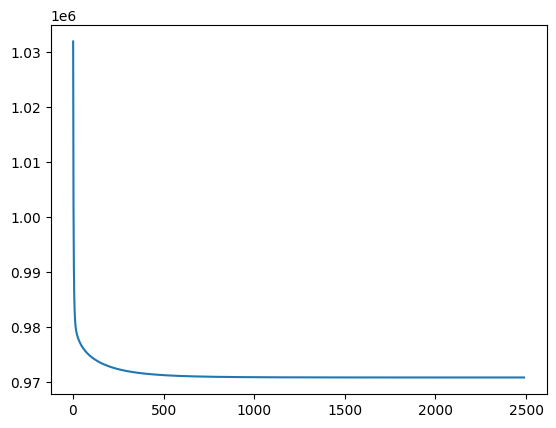

In [37]:
from matplotlib import pyplot as plt

plt.plot(f_vals)

In [68]:
b_u_hat = x_new[:num_users]
b_i_hat = x_new[num_users:]

## Train Prediction

In [114]:
train_pred_1 = []
for i, row in df.iterrows():
    user = row['user_id']
    song = row['song_id']

    user_index = users_hash[user]
    bu = b_u_hat[user_index][0]

    song_index = songs_hash[song]
    bi = b_i_hat[song_index][0]

    train_pred_1.append(r_avg + bu + bi)

In [127]:
from sklearn.metrics import mean_squared_error as MSE

mse_train_1 = np.round(MSE(y_true=df.iloc[:,2], y_pred=train_pred_1),3)
sse_train_1 = np.sum(np.square(df.iloc[:,2] - train_pred_1))

print(f'MSE in Part 1 on train set: {mse_train_1}\n'
      f'SSE in Part 1 on train set: {sse_train_1}')

MSE in Part 1 on train set: 13347711.389
SSE in Part 1 on train set: 1075852233400.2699


## Test Prediction

In [141]:
test_pred_1 = []
for i, row in test_df.iterrows():
    user = row['user_id']
    song = row['song_id']
    if user not in users_hash.keys():
        bu = 0
    else:
        user_index = users_hash[user]
        bu = int(b_u_hat[user_index])
    if song not in songs_hash.keys():
        bi = 0
    else:
        song_index = songs_hash[song]
        bi = int(b_i_hat[song_index])
    test_pred_1.append(r_avg + bu + bi)

# Part 2 - ALS

In [87]:
# user dictionary
sorted_users = sorted(df.iloc[:, 0].unique())
users_hash = {}
for i in range(len(sorted_users)):
    users_hash[sorted_users[i]] = i

In [88]:
# song dictionary
sorted_songs = sorted(df.iloc[:, 1].unique())
songs_hash = {}
for j in range(len(sorted_songs)):
    songs_hash[sorted_songs[j]] = j

In [89]:
num_users = len(sorted_users)  # Number of users
num_songs = len(sorted_songs)  # Number of songs
num_users, num_songs

(1891, 16529)

In [90]:
# alternating least squares step
def als_step(latent_vectors, fixed_vecs, ratings, _lambda=0, type='user'):
    """
    One of the two ALS steps. Solve for the latent vectors
    specified by type.
    """
    if type == 'user':
        # calculating P, Q is fixed
        QTQ = fixed_vecs.T.dot(fixed_vecs)
        lambdaI = np.eye(QTQ.shape[0]) * _lambda

        for u in range(latent_vectors.shape[0]):  # iterate over P rows and R Rows
            latent_vectors[u, :] = (la.solve((QTQ + lambdaI),
                                             (ratings[u, :].dot(fixed_vecs)).transpose())).ravel()
    elif type == 'item':
        # calculating Q, P is fixed
        PTP = fixed_vecs.T.dot(fixed_vecs)
        lambdaI = np.eye(PTP.shape[0]) * _lambda

        for i in range(latent_vectors.shape[0]):
            latent_vectors[i, :] = (la.solve((PTP + lambdaI),
                                             (ratings[:, i].T.dot(fixed_vecs)).transpose())).ravel()
    return latent_vectors

In [91]:
# create the sparse ratings matrix
R = sp.lil_matrix((num_users, num_songs))

for i, row in df.iterrows():
    # Set the nonzero entries in the current row
    user = users_hash[row['user_id']]
    song = songs_hash[row['song_id']]
    rating = row['weight']
    R[user, song] = rating

R_rows = R.tocsr()  # we'll use to slice rows
R_cols = R.tocsc()  # we'll use to slice column

In [158]:
K = 20
user_matrix = np.random.random((num_users, K))  # TODO: change to ones, but it throws an error
song_matrix = np.zeros((num_songs, K))
iterations = 10
for _ in range(iterations):
    old_songs, old_users = song_matrix, user_matrix
    song_matrix = als_step(song_matrix,
                           user_matrix,
                           R_cols,
                           type='item')
    user_matrix = als_step(user_matrix,
                           song_matrix,
                           R_rows,
                           type='user')


## Train Prediction

In [93]:
# predictions = np.zeros((num_users, num_songs))
# for u in range(num_users):
#     for s in range(num_songs):
#         predictions[u, s] = user_matrix[u, :].dot(song_matrix[s, :])


In [103]:
train_pred_2 = []
for i, row in df.iterrows():
    user = row['user_id']
    song = row['song_id']

    user_index = users_hash[user]
    song_index = songs_hash[song]

    pred = user_matrix[user_index, :].dot(song_matrix[song_index, :])

    train_pred_2.append(pred)

5 iterations
10 iterations
15 iterations
20 iterations
50 iterations
100 iterations


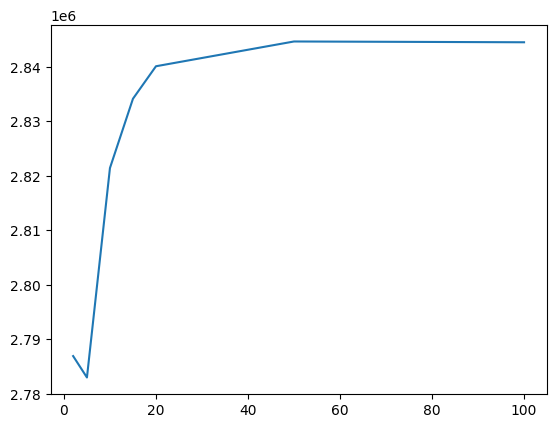

2 iterations
5 iterations
10 iterations
15 iterations
20 iterations
50 iterations
100 iterations


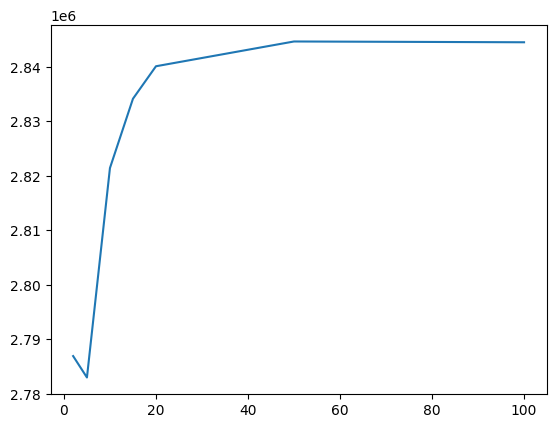

In [165]:
def calculate_part_2(iterations):
    np.random.seed(12345)
    print(f'{iterations} iterations')
    K = 20
    user_matrix = np.random.random((num_users, K))  # TODO: change to ones, but it throws an error
    song_matrix = np.zeros((num_songs, K))
    for _ in range(iterations):
        start = False
        old_songs, old_users = song_matrix, user_matrix
        song_matrix = als_step(song_matrix,
                               user_matrix,
                               R_cols,
                               type='item')
        user_matrix = als_step(user_matrix,
                               song_matrix,
                               R_rows,
                               type='user')
    train_pred_2 = []
    for i, row in df.iterrows():
        user = row['user_id']
        song = row['song_id']

        user_index = users_hash[user]
        song_index = songs_hash[song]

        pred = user_matrix[user_index, :].dot(song_matrix[song_index, :])

        train_pred_2.append(pred)

    mse = np.round(MSE(y_true=df.iloc[:,2], y_pred=train_pred_2), 3)
    return mse
iterations = (2,5,10,15,20,50,100)
mse_list = [calculate_part_2(i) for i in iterations]
plt.plot(iterations, mse_list)

In [126]:
from sklearn.metrics import mean_squared_error as MSE

mse_train_2 = np.round(MSE(y_true=df.iloc[:,2], y_pred=train_pred_2), 3)
sse_train_2 = np.sum(np.square(df.iloc[:,2] - train_pred_2))
print(f'MSE in Part 2 on train set: {mse_train_2}\n'
      f'SSE in Part 2 on train set: {sse_train_2}\n'
      f'Reminder\n'
      f'Improvement of {mse_train_1 - mse_train_2} in the MSE\n'
      f'Improvement of {sse_train_1 - sse_train_2} in the SSE')

MSE in Part 2 on train set: 2802624.672
SSE in Part 2 on train set: 225897153786.63385
Reminder
Improvement of 10545086.717 in the MSE
Improvement of 849955079613.636 in the SSE


## Test Prediction

In [ ]:
mean_user_entry = user_matrix.mean()
median_user_entry = np.median(user_matrix)

mean_song_entry = song_matrix.mean()
median_song_entry = np.median(song_matrix)

In [144]:
test_pred_2 = []
for i, row in test_df.iterrows():
    user = row['user_id']
    song = row['song_id']
    if user not in users_hash.keys():
        user_vec = np.random.uniform(median_user_entry,1,K)
    else:
        user_index = users_hash[user]
        user_vec = user_matrix[user_index]
    if song not in songs_hash.keys():
        song_vec = np.random.uniform(median_song_entry,1,K)
    else:
        song_index = songs_hash[song]
        song_vec = song_matrix[song_index]
    test_pred_2.append(user_vec.dot(song_vec))

# Part 3

In [166]:
# Perform SVD on the sparse matrix
# k = Number of singular values/vectors to use
U, S, V = svds(R_rows, k=20)

# Reconstruct the matrix using k singular values/vectors
reduced_R = U.dot(sp.diags(S).dot(V))

la.norm(R - reduced_R) ** 2

244303013454.14975

In [173]:
from sklearn.decomposition import TruncatedSVD
movie_svd = TruncatedSVD(n_components=20)
movie_features = movie_svd.fit_transform(R_rows)
movie_features


array([[ 1.61986513e+02,  8.16646444e-01,  4.15984691e+01, ...,
         1.74729460e+01, -2.21394839e+01,  1.45697821e+01],
       [ 9.83777088e-01,  1.04461350e-01,  2.58215767e-01, ...,
        -2.58216215e-01,  7.63471391e-01,  1.75510303e+00],
       [ 1.72788891e+03,  2.87772251e+00,  5.79312401e+01, ...,
        -5.16097506e+00,  1.75152615e+02, -2.76223694e+01],
       ...,
       [ 4.91562118e+00,  1.20800706e+01,  2.17293498e+03, ...,
        -1.99362494e+02, -4.39169951e+02,  1.83718364e+03],
       [ 2.32986067e+00,  1.15089461e+01,  5.04095525e+02, ...,
         2.63574394e+01,  2.70538707e+02, -5.24158997e+01],
       [ 5.74155471e+00,  3.02752030e+01,  1.36511058e+03, ...,
        -4.46342309e+01,  2.22556927e+02,  2.02332855e+02]])

In [174]:
R_rows

<1891x16529 sparse matrix of type '<class 'numpy.float64'>'
	with 80602 stored elements in Compressed Sparse Row format>